<a href="https://colab.research.google.com/github/juanglondono-coder/deep-learning-final-ydl-air-pollution/blob/main/03_modelo_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
%matplotlib inline

# Crear carpeta de resultados si no existe
os.makedirs("results", exist_ok=True)

0. Preprocesamiento de datos

In [3]:
df = pd.read_csv('train.csv')
print("Shape original:", df.shape)
df.head()

Shape original: (6218, 14)


,Unnamed: 0,Datetime,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,0,2004-03-10 18:00:00,2.6,1360.00,150,11.881723,166.0,1056.25,113.0,1692.00,1267.50,13.60,48.875001,0.757754
1,1,2004-03-10 19:00:00,2.0,1292.25,112,9.397165,103.0,1173.75,92.0,1558.75,972.25,13.30,47.700000,0.725487
2,2,2004-03-10 20:00:00,2.2,1402.00,88,8.997817,131.0,1140.00,114.0,1554.50,1074.00,11.90,53.975000,0.750239
3,3,2004-03-10 21:00:00,2.2,1375.50,80,9.228796,172.0,1092.00,122.0,1583.75,1203.25,11.00,60.000000,0.786713
4,4,2004-03-10 22:00:00,1.6,1272.25,51,6.518224,131.0,1205.00,116.0,1490.00,1110.00,11.15,59.575001,0.788794


In [4]:
# 1.1. Eliminar índice viejo si existe
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

# 1.2. Convertir Datetime a datetime y ordenar por tiempo
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.sort_values('Datetime').reset_index(drop=True)

df.info()
# 1.3. Reemplazar -200 por NaN en columnas donde este valor es código de dato inválido
cols_with_minus200 = ['CO(GT)', 'NMHC(GT)', 'NOx(GT)', 'NO2(GT)']

for c in cols_with_minus200:
    df[c] = df[c].replace(-200, np.nan)

df[cols_with_minus200].describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6218 entries, 0 to 6217
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Datetime      6218 non-null   datetime64[ns]
 1   CO(GT)        6218 non-null   float64       
 2   PT08.S1(CO)   6218 non-null   float64       
 3   NMHC(GT)      6218 non-null   int64         
 4   C6H6(GT)      6218 non-null   float64       
 5   NOx(GT)       6218 non-null   float64       
 6   PT08.S3(NOx)  6218 non-null   float64       
 7   NO2(GT)       6218 non-null   float64       
 8   PT08.S4(NO2)  6218 non-null   float64       
 9   PT08.S5(O3)   6218 non-null   float64       
 10  T             6218 non-null   float64       
 11  RH            6218 non-null   float64       
 12  AH            6218 non-null   float64       
dtypes: datetime64[ns](1), float64(11), int64(1)
memory usage: 631.6 KB


,CO(GT),NMHC(GT),NOx(GT),NO2(GT)
count,4771.000000,887.000000,4812.000000,4809.000000
mean,2.126200,218.607666,195.608479,99.113745
std,1.437417,206.615130,185.525983,41.416704
min,0.100000,7.000000,2.000000,2.000000
25%,1.100000,66.000000,75.000000,68.000000
50%,1.800000,145.000000,137.000000,96.000000
75%,2.800000,297.000000,246.000000,124.000000
max,11.900000,1189.000000,1389.000000,288.000000


2. Definir target, filtrar filas válidas y preparar X / y

In [5]:
# 2.1. Definir variable objetivo
target_col = 'NMHC(GT)'

# 2.2. Eliminar filas donde el target es NaN
df = df[~df[target_col].isna()].copy()
print("Shape después de filtrar filas sin target:", df.shape)

df[target_col].describe()

Shape después de filtrar filas sin target: (887, 13)


,NMHC(GT)
count,887.000000
mean,218.607666
std,206.615130
min,7.000000
25%,66.000000
50%,145.000000
75%,297.000000
max,1189.000000


In [6]:
# 2.3. Definir columnas de entrada (todas menos Datetime y el target)
feature_cols = [c for c in df.columns if c not in ['Datetime', target_col]]
print("Features:", feature_cols)

Features: ['CO(GT)', 'PT08.S1(CO)', 'C6H6(GT)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']


In [7]:
# 2.4. Separar X e y
X_raw = df[feature_cols]
y = df[target_col]

# 2.5. Imputar faltantes en features con la mediana
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X_raw)

# Volver a DataFrame para comodidad
X = pd.DataFrame(X_imputed, columns=feature_cols, index=df.index)

In [8]:
print("NaNs en X después de imputar:")
print(X.isna().sum())
print("Shapes finales X, y:", X.shape, y.shape)

NaNs en X después de imputar:
CO(GT)          0
PT08.S1(CO)     0
C6H6(GT)        0
NOx(GT)         0
PT08.S3(NOx)    0
NO2(GT)         0
PT08.S4(NO2)    0
PT08.S5(O3)     0
T               0
RH              0
AH              0
dtype: int64
Shapes finales X, y: (887, 11) (887,)


3. División en train / valid

In [9]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

In [10]:
print("X_train:", X_train.shape)
print("X_val:", X_val.shape)

X_train: (709, 11)
X_val: (178, 11)


4. Implementar modelo baseline (Random forest)

In [11]:
# 4.1. Definir y entrenar RandomForestRegressor
rf = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

In [12]:
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=42)

In [13]:
# 4.2. Predicciones y métricas en validación
y_pred_rf = rf.predict(X_val)

mae_rf = mean_absolute_error(y_val, y_pred_rf)
mse_rf = mean_squared_error(y_val, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)

In [14]:
print("RandomForest - MAE  :", mae_rf)
print("RandomForest - RMSE :", rmse_rf)

RandomForest - MAE  : 29.118333333333336
RandomForest - RMSE : 49.7932775126892


5. Implementar modelo baseline (Regresión lineal)

In [15]:
from sklearn.linear_model import LinearRegression

# 5.1. Regresión lineal como baseline aún más simple
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_pred_lr = linreg.predict(X_val)

In [16]:
mae_lr = mean_absolute_error(y_val, y_pred_lr)
mse_lr = mean_squared_error(y_val, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)

In [17]:
print("LinearRegression - MAE  :", mae_lr)
print("LinearRegression - RMSE :", rmse_lr)

LinearRegression - MAE  : 56.525761124149284
LinearRegression - RMSE : 86.43637408637763


6. Comparar y guardar métricas en CSV

In [18]:
metrics_baseline = pd.DataFrame({
    'model': ['RandomForest', 'LinearRegression'],
    'MAE':   [mae_rf, mae_lr],
    'RMSE':  [rmse_rf, rmse_lr]
})

In [19]:
metrics_baseline

,model,MAE,RMSE
0,RandomForest,29.118333,49.793278
1,LinearRegression,56.525761,86.436374


In [20]:
# Guardar métricas en results/
metrics_path = os.path.join("results", "baseline_metrics.csv")
metrics_baseline.to_csv(metrics_path, index=False)
print("Métricas guardadas en:", metrics_path)

Métricas guardadas en: results/baseline_metrics.csv


7. Gráficas

7.1. Random forest

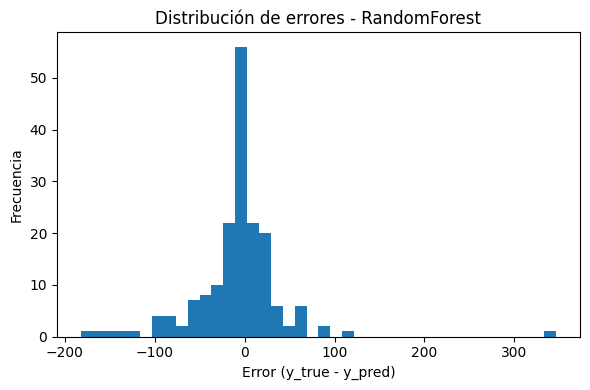

In [21]:
import matplotlib.pyplot as plt

# Histograma de errores
errors_rf = y_val - y_pred_rf

plt.figure(figsize=(6,4))
plt.hist(errors_rf, bins=40)
plt.xlabel('Error (y_true - y_pred)')
plt.ylabel('Frecuencia')
plt.title('Distribución de errores - RandomForest')
plt.tight_layout()
plt.show()

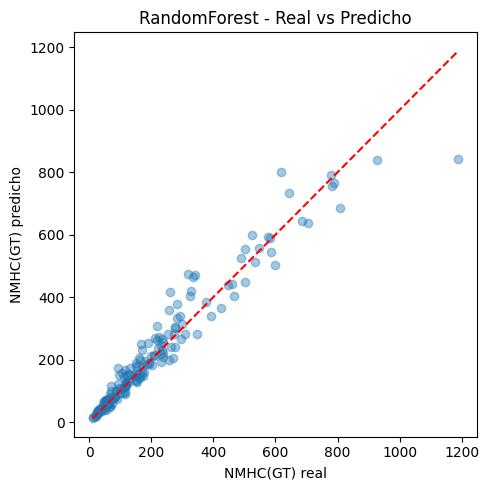

In [22]:
# Real vs predicho
plt.figure(figsize=(5,5))
plt.scatter(y_val, y_pred_rf, alpha=0.4)
plt.xlabel('NMHC(GT) real')
plt.ylabel('NMHC(GT) predicho')
plt.title('RandomForest - Real vs Predicho')

# Línea y = x
min_val = min(y_val.min(), y_pred_rf.min())
max_val = max(y_val.max(), y_pred_rf.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--')

plt.tight_layout()
plt.show()

7.2. Regresion lineal

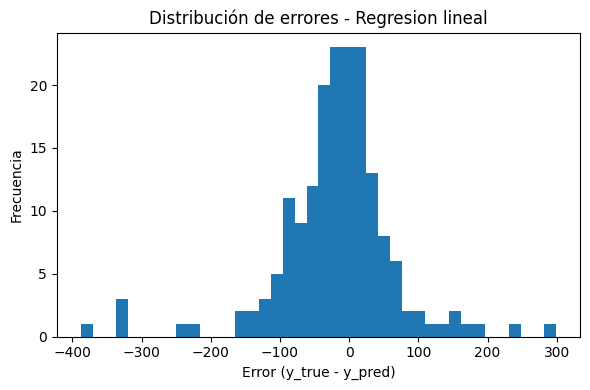

In [23]:
# Histograma de errores
errors_rf = y_val - y_pred_lr

plt.figure(figsize=(6,4))
plt.hist(errors_rf, bins=40)
plt.xlabel('Error (y_true - y_pred)')
plt.ylabel('Frecuencia')
plt.title('Distribución de errores - Regresion lineal')
plt.tight_layout()
plt.show()

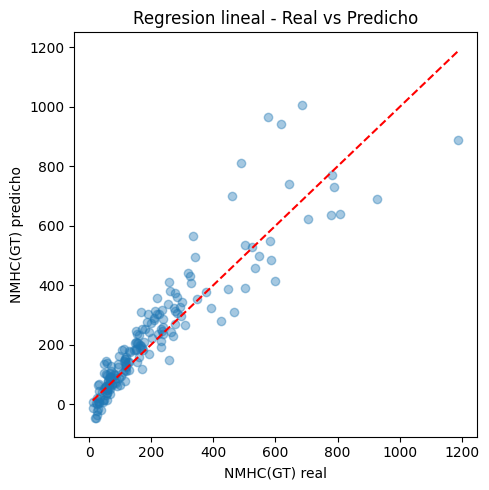

In [24]:
# Real vs predicho
plt.figure(figsize=(5,5))
plt.scatter(y_val, y_pred_lr, alpha=0.4)
plt.xlabel('NMHC(GT) real')
plt.ylabel('NMHC(GT) predicho')
plt.title('Regresion lineal - Real vs Predicho')

# Línea y = x
min_val = min(y_val.min(), y_pred_rf.min())
max_val = max(y_val.max(), y_pred_rf.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--')

plt.tight_layout()
plt.show()